In [1]:
import ipywidgets as widgets
from IPython.display import display
import numpy as np
import numpy.linalg as la
import matplotlib
%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import pandas as pd
from data_parser import parse
from data_modification import *
from visualization.plot_vcg import plot_vcg_axes, plot_3d_vcg, create_cmap, multivariate_scatter, univariate_scatter

%load_ext autoreload
%autoreload 2

In [4]:
patient_no = 1
data_path = 'H:/Yngve/Dropbox/SimulaSummerSchool_Group9/data/lbbb_lvdyssync'

### Load data

In [5]:
patient = normalise_patient(parse(initial_path=data_path, patient_number=patient_no))
patient = resample_patient(patient)
patient = project_patient(patient)
patient_center = center_patient(patient)
patient_cyl = cylindrical_patient(patient_center)

In [8]:
dyssyncs = patient_cyl['desync'].values
dm = create_data_matrix(patient_cyl)
dm = dm[dyssyncs != 0]
dyssyncs_clean = dyssyncs[dyssyncs != 0]

# Get offset vector:
mean_vals = dm.mean(axis=0, keepdims=True)

# Center data matrix:
dm_center = dm - mean_vals

# 3D plots of heart vectors

In [ ]:
fig, _, _ = plot_3d_vcg(np.array(patient['vcg_real']))
fig.suptitle('Real VCG')

In [ ]:
fig, ax, wire = plot_3d_vcg(np.array(patient['vcg_model'][0]))
fig.suptitle('Modelled VCG no 0')

pat_slider = widgets.IntSlider(0, 0, len(patient['vcg_model']), description='Sim no:')
plot_button = widgets.Button(description='Plot VCG')

def replot(click):
    global fig, ax, wire, pat_slider
    fig, ax, wire = plot_3d_vcg(np.array(patient['vcg_model'][pat_slider.value]), figure=fig, axes=ax, wire=wire)
    fig.suptitle('Modelled VCG no{}'.format(pat_slider.value))
    
plot_button.on_click(replot)

display(pat_slider, plot_button)

# VCG's in cartesian coordinates

In [ ]:
fig, _, _, = plot_vcg_axes(np.array(patient['vcg_real']))
fig.suptitle('Real VCG')

In [ ]:
fig, ax, plots = plot_vcg_axes(np.array(patient['vcg_model'][0]))
fig.suptitle('Modelled VCG no 0')
pat_slider = widgets.IntSlider(0, 0, len(patient['vcg_model']), description='Sim no:')
plot_button = widgets.Button(description='Plot VCG')

def replot(click):
    global fig, ax, plots, pat_slider
    plot_vcg_axes(np.array(patient['vcg_model'][pat_slider.value]), figure=fig, axes=ax, plots=plots)
    fig.suptitle('Modelled VCG no {}'.format(pat_slider.value))

plot_button.on_click(replot)
display(pat_slider, plot_button)

# VCGs in cylindrical coordinates
### After centering

<IPython.core.display.Javascript object>


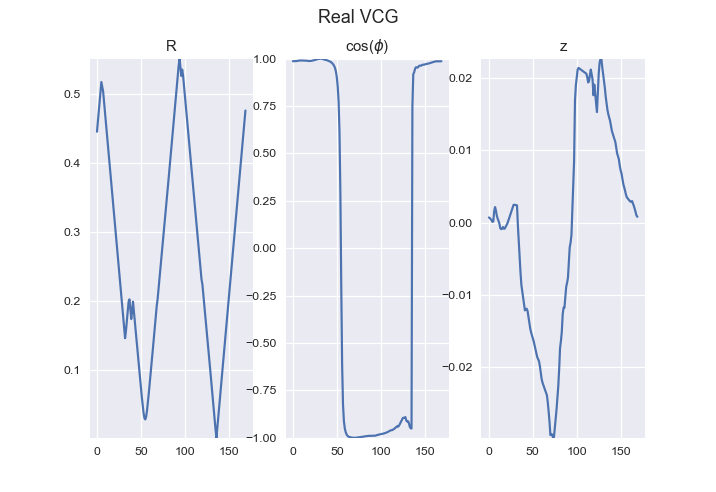

In [4]:
transforms = [None, lambda x: np.cos(x), None]
fig, _, _, = plot_vcg_axes(np.array(patient_cyl['vcg_real']), titles=['R', 'cos($\phi$)', 'z'], transforms=transforms)
fig.suptitle('Real VCG')

<IPython.core.display.Javascript object>


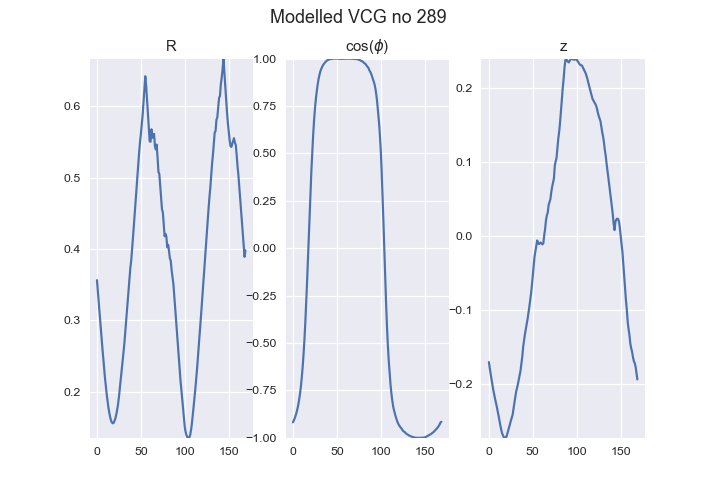

In [7]:
transforms = [None, lambda x: np.cos(x), None]
fig, ax, plots = plot_vcg_axes(np.array(patient_cyl['vcg_model'][0]), titles=['R', '$cos(\phi)$', 'z'], transforms=transforms)
fig.suptitle('Modelled VCG no 0')
pat_slider = widgets.IntSlider(0, 0, len(patient['vcg_model']), description='Sim no:')
plot_button = widgets.Button(description='Plot VCG')

def replot(click):
    global fig, ax, plots, pat_slider
    plot_vcg_axes(np.array(patient_cyl['vcg_model'][pat_slider.value]), figure=fig, axes=ax, plots=plots, titles=['R', 'cos($\phi$)', 'z'], transforms=transforms)
    fig.suptitle('Modelled VCG no {}'.format(pat_slider.value))

plot_button.on_click(replot)
display(pat_slider, plot_button)

# Exploration of basic features vs dyssynchrony

## 2D plots - not much information here

In [11]:
# General properties for plotting
transforms = [None, lambda x: np.cos(x), None]
cmap = create_cmap(
    dataset = dyssyncs[dyssyncs != 0],
    cmap = 'viridis'
)

In [ ]:
fig, axes, plots = fig, ax, plots = plot_vcg_axes(
    vcg = np.array(patient_cyl['vcg_model'][0]), 
    color = cmap.to_rgba(dyssyncs[0]),
    titles = ['R', '$cos(\phi)$', 'z'], 
    transforms = transforms
)

for dyssync, simulation in zip(dyssyncs, patient_cyl['vcg_model']):
    simulation = np.array(simulation)
    color = np.array(cmap.to_rgba(dyssync))
    color[3] = 0.1
    fig, axes, _ = plot_vcg_axes(
        vcg = simulation,
        figure = fig,
        axes = axes,
        color = color,
        titles = ['R', '$cos(\phi)$', 'z'],
        transforms = transforms,
        set_lims=False
    )

axes[0].set_ylim(0, 1)
axes[2].set_ylim(-1, 1)

## 3D plots - not much info here

<IPython.core.display.Javascript object>


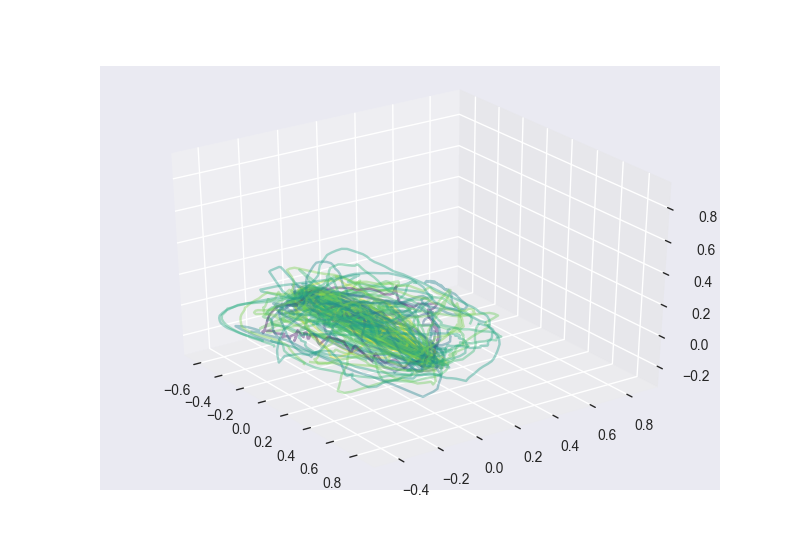

(-0.30578621921700122, 0.92996220882867231)

In [19]:
color = np.array(cmap.to_rgba(dyssyncs[0]))
color[3] = 0.4
fig, axes, _ = plot_3d_vcg(np.array(patient_center['vcg_model'][0]), color=color, set_lims=False)

min_x, min_y, min_z = [np.float('inf')]*3
max_x, max_y, max_z = [-np.float('inf')]*3
for dyssync, simulation in zip(dyssyncs[0::10], patient_center['vcg_model'][0::10]):
    # Set min and max
    min_x = min(np.min(simulation['px']), min_x)
    min_y = min(np.min(simulation['py']), min_y)
    min_z = min(np.min(simulation['pz']), min_z)
    
    max_x = max(np.max(simulation['px']), max_x)
    max_y = max(np.max(simulation['py']), max_y)
    max_z = max(np.max(simulation['pz']), max_z)
    
    simulation = np.array(simulation)
    color = np.array(cmap.to_rgba(dyssync))
    color[3] = 0.4 
    fig, axes, _ = plot_3d_vcg(
        vcg = simulation,
        figure = fig,
        axes = axes,
        color = color,
        set_lims=False
    )

axes.set_xlim(min_x, max_x)
axes.set_ylim(min_y, max_x)
axes.set_zlim(min_z, max_x)

# PCA scatter plot

### Compute PCA

In [20]:
# Compute principal components:
U, S, V = np.linalg.svd(dm_center)

<IPython.core.display.Javascript object>


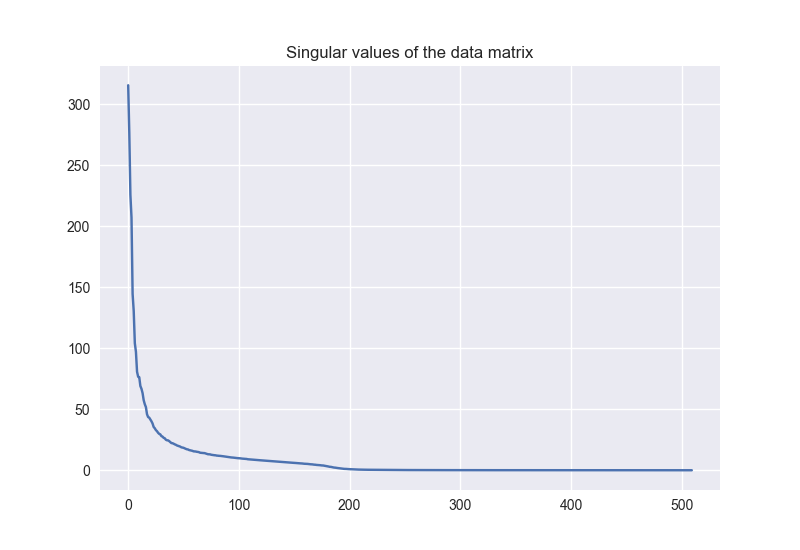

In [21]:
plt.figure()
plt.plot(S)
plt.title('Singular values of the data matrix')

## Perform coordinate change to principal axes

<IPython.core.display.Javascript object>


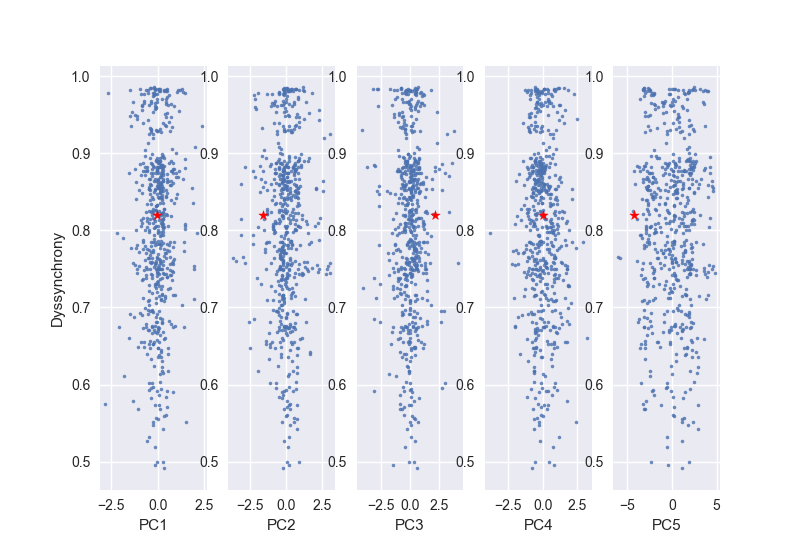

<IPython.core.display.Javascript object>


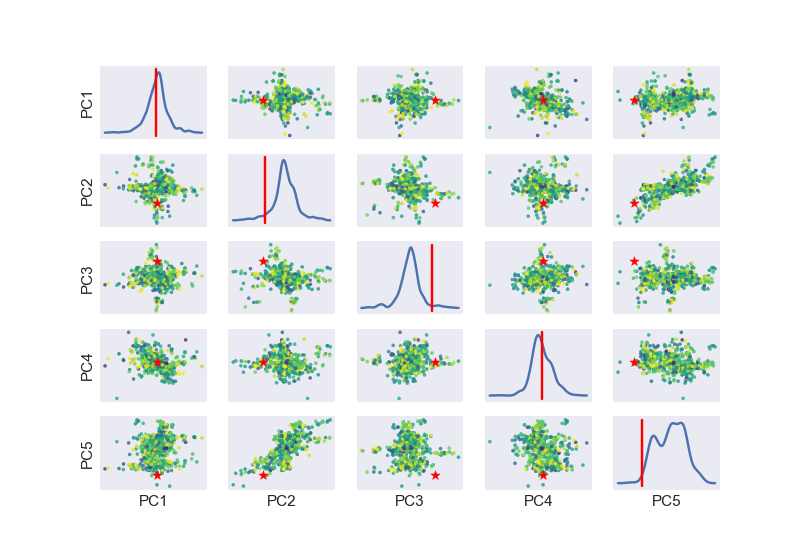

In [22]:
pca_matrix = dm_center.dot(V)
patient_vector = np.reshape(patient_cyl['vcg_real'].values, [np.prod(patient_cyl['vcg_real'].values.shape)])
pca_real = (patient_vector - mean_vals).dot(V)[0]

colors = cmap.to_rgba(dyssyncs)
column_titles = ['PC{}'.format(i+1) for i in range(pca_matrix.shape[1])] + ['Dyssynchrony']

pca_df = pd.DataFrame(
    np.concatenate([pca_matrix, dyssyncs_clean.reshape([-1, 1])], axis=1), 
    columns = column_titles
)

univariate_scatter(
    data_frame = pca_df,
    dyssynchrony = dyssyncs_clean,
    real_point = pca_real,
    real_dys = patient_cyl['opt_desync'],
    no_components=5
)

multivariate_scatter(
    data_frame = pca_df,
    no_components = 5,
    colour_by = 'Dyssynchrony',
    real_point = pca_real
)

# Kernel PCA

In [23]:
from sklearn.decomposition import KernelPCA, PCA

gamma = 0.0025


kpca = KernelPCA(kernel='rbf', gamma=gamma)

X_kpca = kpca.fit_transform(dm_center)
#X_back = kpca.inverse_transform(X_kpca)
kpca_real = kpca.transform((patient_vector - mean_vals))[0]

column_titles = ['K-PC{}'.format(i+1) for i in range(X_kpca.shape[1])] + ['Dyssynchrony']
kpca_df = pd.DataFrame(
    np.concatenate([X_kpca, dyssyncs_clean.reshape([dyssyncs_clean.shape[0], 1])], axis=1), 
    columns = column_titles
)

<IPython.core.display.Javascript object>


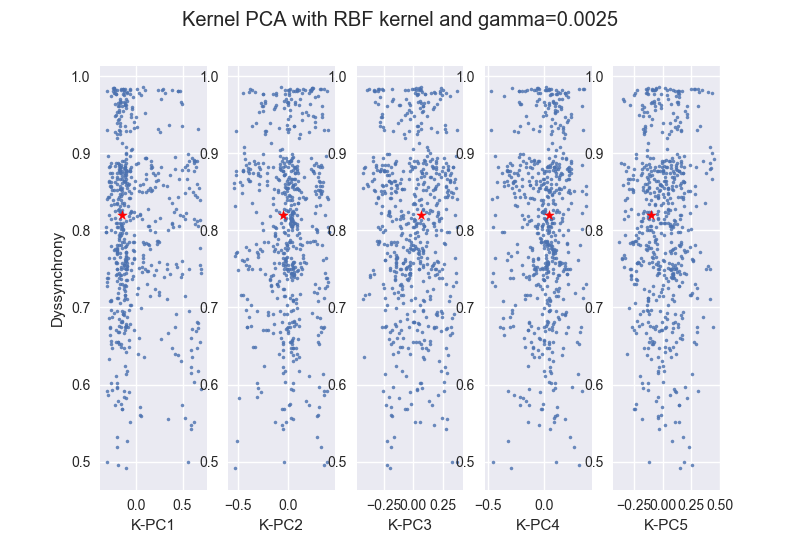

<IPython.core.display.Javascript object>


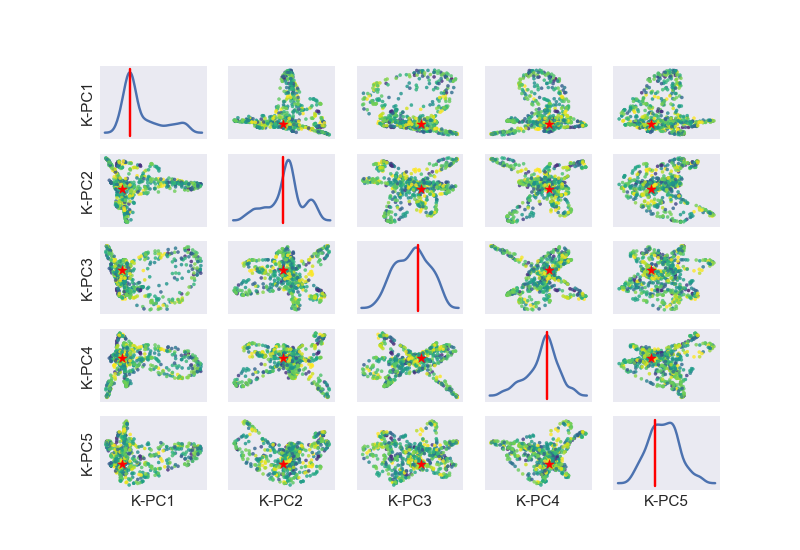

In [24]:
univariate_scatter(
    data_frame = kpca_df,
    dyssynchrony = dyssyncs_clean,
    real_point = kpca_real,
    real_dys = patient_cyl['opt_desync'],
    no_components=5
)


plt.figure(plt.get_fignums()[-1]).suptitle('Kernel PCA with RBF kernel and gamma={}'.format(gamma))

multivariate_scatter(
    data_frame = kpca_df,
    no_components = 5,
    colour_by = 'Dyssynchrony',
    real_point = kpca_real
)

# Isomaps

<IPython.core.display.Javascript object>


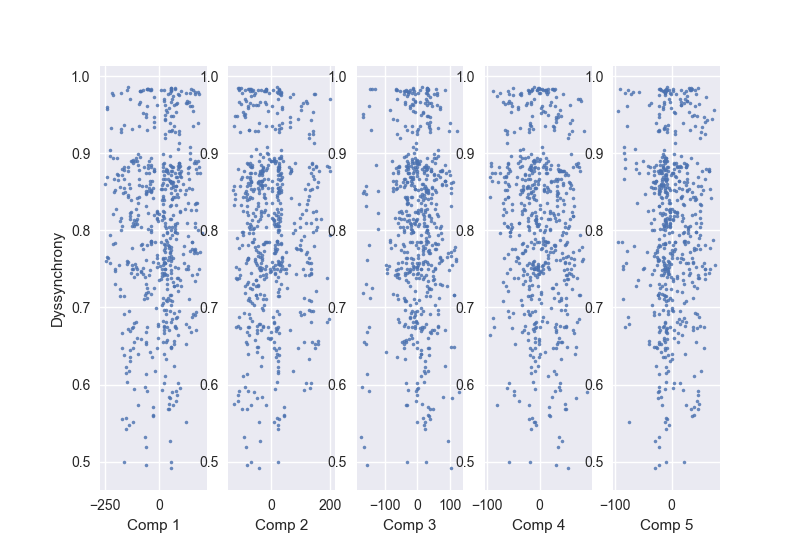

<IPython.core.display.Javascript object>


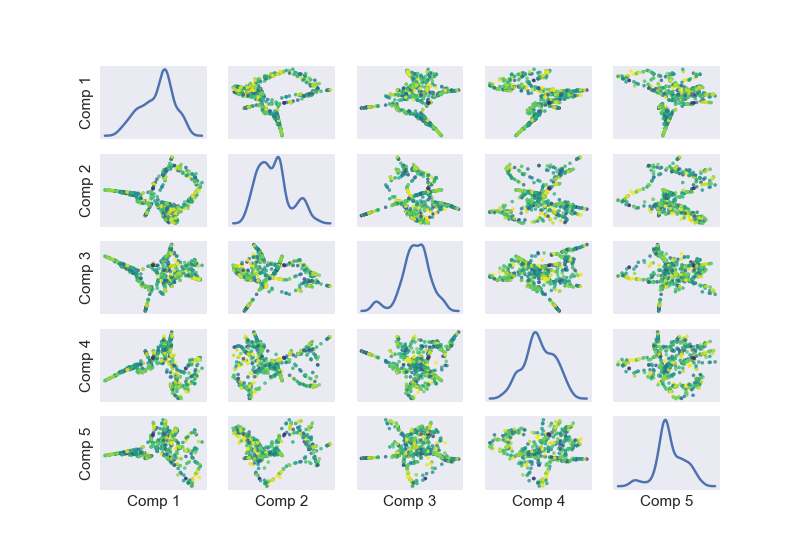

In [26]:
from sklearn.manifold import Isomap

iso_4 = Isomap(n_neighbors=4, n_components=5).fit_transform(dm_center)


isomap4_df = pd.DataFrame(
    np.concatenate((iso_4, dyssyncs_clean.reshape([-1, 1])), axis=1),
    columns = ['Comp {}'.format(i+1) for i in range(5)] + ['Dyssynchrony']
)

univariate_scatter(
    data_frame = isomap4_df,
    dyssynchrony = dyssyncs_clean,
    no_components = 5
)

multivariate_scatter(
    data_frame = isomap4_df,
    no_components = 5,
    colour_by = 'Dyssynchrony',
)

# Perform clustering to see if VCG's cluster by dyssynchrony

In [30]:
from sklearn.cluster import SpectralClustering


n_clusters=9
sp = SpectralClustering(
    n_clusters = n_clusters,
    affinity = 'nearest_neighbors',
    n_neighbors = 15
)

sp_clusters = sp.fit_predict(dm_center)


In [31]:
cluster_dys = [dyssyncs_clean[sp_clusters == i] for i in range(n_clusters)]

<IPython.core.display.Javascript object>


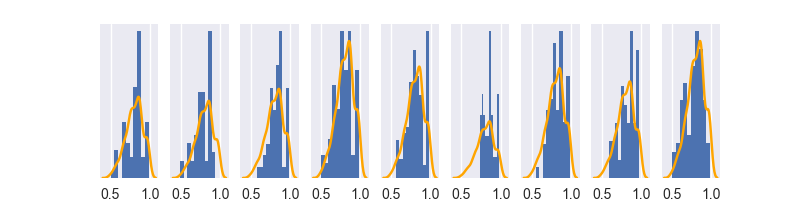

In [32]:
fig = plt.figure(figsize=(8, 2))

for i, cluster in enumerate(cluster_dys):
    fig.add_subplot(1, n_clusters, i+1)
    plt.hist(cluster, normed=True)
    sns.kdeplot(dyssyncs_clean, c='orange')
    plt.yticks([])

The above figure shows each of the clusters dyssynchrony histograms in blue the density plot of all the dyssynchronies in orange.

# Perform linear discriminant analysis

In [48]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(solver='eigen', shrinkage='auto', store_covariance=True)
# Create different classes
classes = (dyssyncs_clean > 0.9).astype(int) \
        + (dyssyncs_clean > 0.8).astype(int)# \
        #+ (dyssyncs_clean > 0.7).astype(int)
lda_transformed = lda.fit_transform(dm_center, classes)

<IPython.core.display.Javascript object>


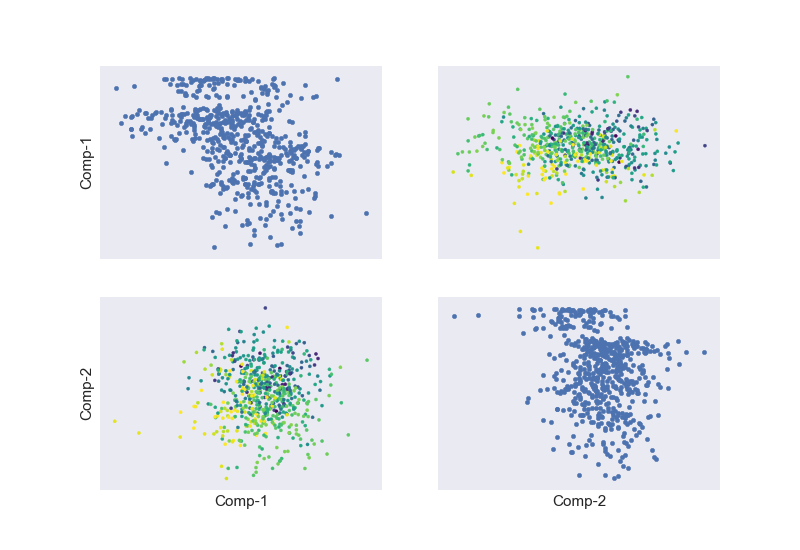

In [58]:
plt.figure()
n_comp = classes.max()
for i in range(n_comp):
    for j in range(n_comp):
        plt.subplot(n_comp, n_comp, j + n_comp*i + 1)
        if i == j:
            plt.scatter(lda_transformed[:, i], dyssyncs_clean, s=10)
        else:
            plt.scatter(lda_transformed[:, i], lda_transformed[:, j], c=dyssyncs_clean, cmap='viridis', s=5)
        plt.yticks([])
        plt.xticks([])
        if i == n_comp-1:
            plt.xlabel('Comp-{}'.format(j+1))
        if j == 0:
            plt.ylabel('Comp-{}'.format(i+1))

The scatterplots on the main diagonal in the figure above have LDA component response on the first axis and dyssynchrony on the second axis.